In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

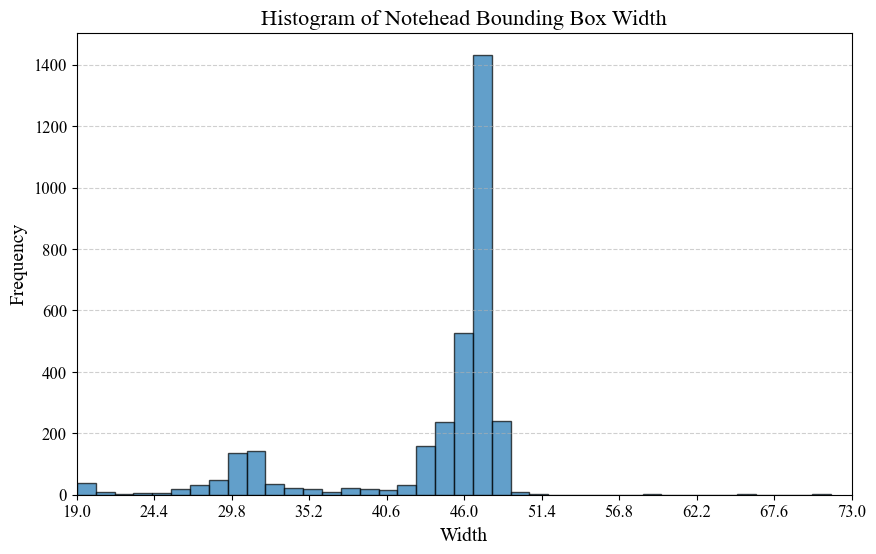

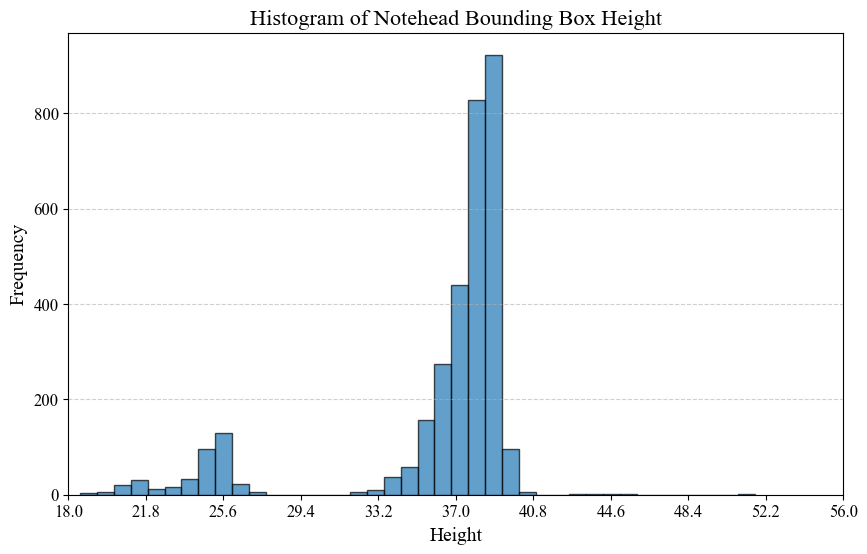

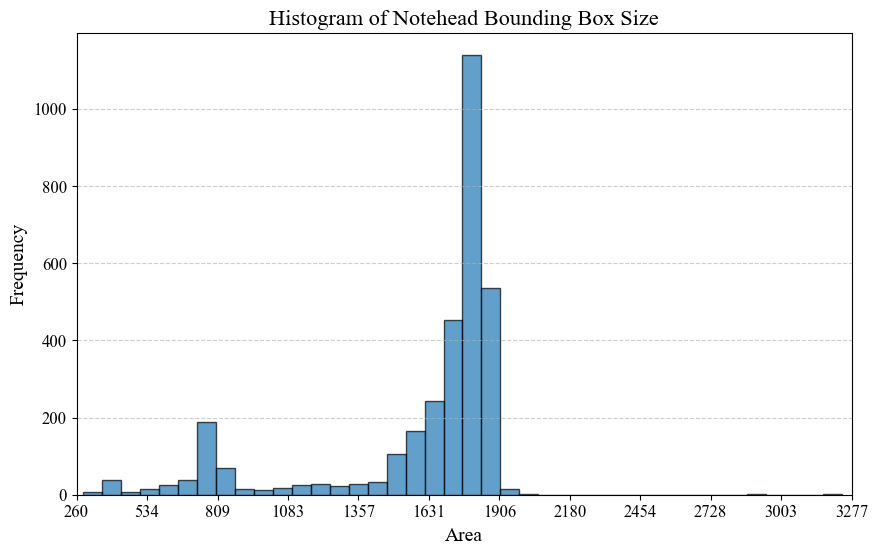

In [11]:
notehead_detection_df = pd.read_csv('notehead_detection.csv')
notehead_detection_df['BoundingBox'] = notehead_detection_df['BoundingBox'].apply(ast.literal_eval)
notehead_detection_df['Width'] = notehead_detection_df['BoundingBox'].apply(lambda x: x[2] - x[0])
notehead_detection_df['Height'] = notehead_detection_df['BoundingBox'].apply(lambda x: x[3] - x[1])

median_width = np.median(notehead_detection_df['Width'])
median_height = np.median(notehead_detection_df['Height'])
median_area = np.median(notehead_detection_df['Area'])
std_width = np.std(notehead_detection_df['Width'])
std_height = np.std(notehead_detection_df['Height'])
std_area = np.std(notehead_detection_df['Area'])

min_width = int(median_width - 4 * std_width)
max_width = int(median_width + 4 * std_width)
min_height = int(median_height - 4 * std_height)
max_height = int(median_height + 4 * std_height)
min_area = int(median_area - 4 * std_area)
max_area = int(median_area + 4 * std_area)

width_filtered = notehead_detection_df['Width'][
    (notehead_detection_df['Width'] >= min_width) & (notehead_detection_df['Width'] <= max_width)]
height_filtered = notehead_detection_df['Height'][
    (notehead_detection_df['Height'] >= min_height) & (notehead_detection_df['Height'] <= max_height)]
area_filtered = notehead_detection_df['Area'][
    (notehead_detection_df['Area'] >= min_area) & (notehead_detection_df['Area'] <= max_area)]

plt.figure(figsize=(10, 6))
plt.hist(width_filtered, bins=40, edgecolor='black', alpha=0.7)
plt.title('Histogram of Notehead Bounding Box Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.xlim(min_width, max_width)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(np.linspace(min_width, max_width, num=11))
plt.savefig('notehead_width.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Height Histogram
plt.figure(figsize=(10, 6))
plt.hist(height_filtered, bins=40, edgecolor='black', alpha=0.7)
plt.title('Histogram of Notehead Bounding Box Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.xlim(min_height, max_height)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(np.linspace(min_height, max_height, num=11))
plt.savefig('notehead_height.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot Area Histogram
plt.figure(figsize=(10, 6))
plt.hist(area_filtered, bins=40, edgecolor='black', alpha=0.7)
plt.title('Histogram of Notehead Bounding Box Size')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.xlim(min_area, max_area)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(np.linspace(min_area, max_area, num=12))
plt.savefig('notehead_size.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
def parse_bounding_box(bbox_str):
    bbox = ast.literal_eval(bbox_str)
    return bbox[0], bbox[1], bbox[2], bbox[3]

def parse_control_point(point_str):
    point = ast.literal_eval(point_str)
    return point[0], point[1]

def format_bounding_box(bbox):
    return [int(coord) for coord in bbox]

def find_notehead(noteheads, x_ref, y_ref, x_range_min, x_range_max):
    candidates = []
    
    for _, note in noteheads.iterrows():
        x_min, y_min, x_max, y_max = parse_bounding_box(note["BoundingBox"])
        if 1400 <= note["Area"] <= 2400:  # Valid notehead size
            if y_min > y_ref and x_range_min <= x_min <= x_range_max:
                candidates.append((y_min, x_min, x_max, y_max))

    if candidates:
        candidates.sort()  # Select the topmost notehead
        y_min, x_min, x_max, y_max = candidates[0]
        return x_min, y_min, x_max, y_max
    return None

def get_image_dimensions(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[0], img.shape[1]  # (height, width)
    return None, None

control_points_df = pd.read_csv("control_points.csv")
notehead_detection_df = pd.read_csv('notehead_detection.csv')
valid_rows = control_points_df[control_points_df["Invalid Bezier Curve"] == 0]

final_rows = []
for _, row in valid_rows.iterrows():
    crop_file_name = row["Crop File Name"]
    x_P0, y_P0 = parse_control_point(row["P0"])
    x_P4, y_P4 = parse_control_point(row["P4"])

    noteheads = notehead_detection_df[notehead_detection_df["File Name"] == crop_file_name]
    start_note = find_notehead(noteheads, x_P0, y_P0, x_P0 - 65, x_P0)
    end_note = find_notehead(noteheads, x_P4, y_P4, x_P4 - 55, x_P4)

    if start_note and end_note:
        image_path = os.path.join("Use", crop_file_name)
        image_height, image_width = get_image_dimensions(image_path)
        row["Image Height"] = image_height
        row["Image Width"] = image_width
        
        row["Start Notehead"] = str(format_bounding_box(start_note))
        row["End Notehead"] = str(format_bounding_box(end_note))
        final_rows.append(row)

final_df = pd.DataFrame(final_rows)
final_df = final_df[["Crop File Name", "Image Height", "Image Width", "BoundingBox in Crop", "P0", "P1", "P2", "P3", "P4", "Start Notehead", "End Notehead"]]
final_df.to_csv('HN685.csv', index=False)

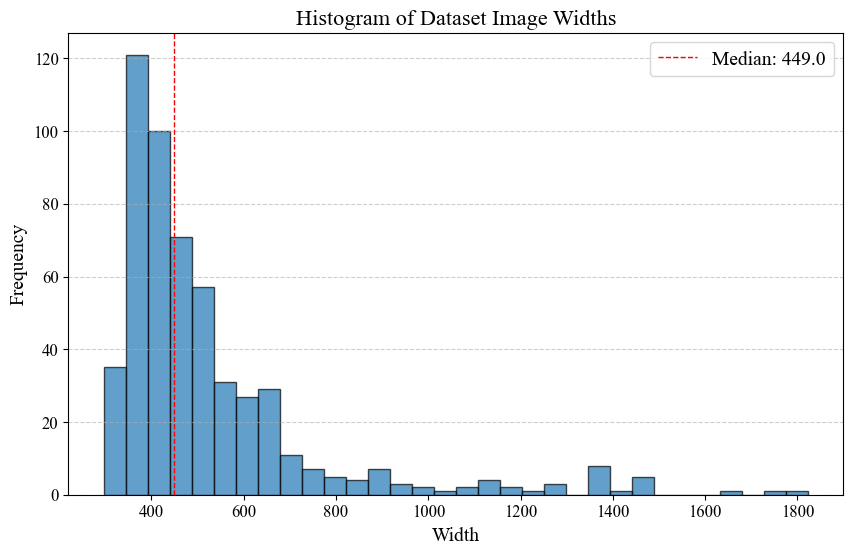

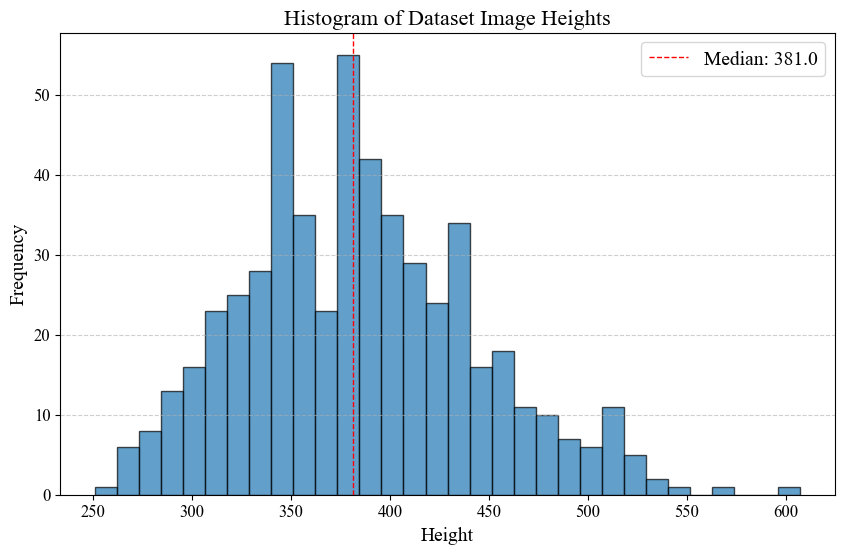

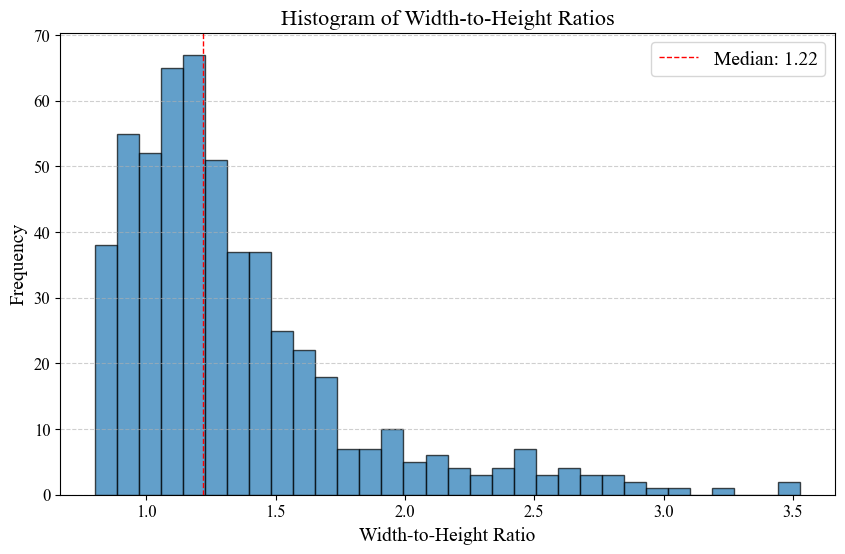

In [13]:
widths = final_df["Image Width"]
heights = final_df["Image Height"]
ratios = final_df["Image Width"] / final_df["Image Height"]

widths = np.array(widths)
heights = np.array(heights)
ratios = np.array(ratios)
median_width = np.median(widths)
median_height = np.median(heights)
median_ratio = np.median(ratios)

plt.figure(figsize=(10, 6))
plt.hist(widths, bins=32, edgecolor="black", alpha=0.7)
plt.axvline(median_width, color="red", linestyle="dashed", linewidth=1, label=f"Median: {median_width}")
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Histogram of Dataset Image Widths")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('image_witdh.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(heights, bins=32, edgecolor="black", alpha=0.7)
plt.axvline(median_height, color="red", linestyle="dashed", linewidth=1, label=f"Median: {median_height}")
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.title("Histogram of Dataset Image Heights")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('image_height.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(ratios, bins=32, edgecolor="black", alpha=0.7)
plt.axvline(median_ratio, color="red", linestyle="dashed", linewidth=1, label=f"Median: {median_ratio:.2f}")
plt.xlabel("Width-to-Height Ratio")
plt.ylabel("Frequency")
plt.title("Histogram of Width-to-Height Ratios")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('image_shape.png', dpi=300, bbox_inches='tight')
plt.show()

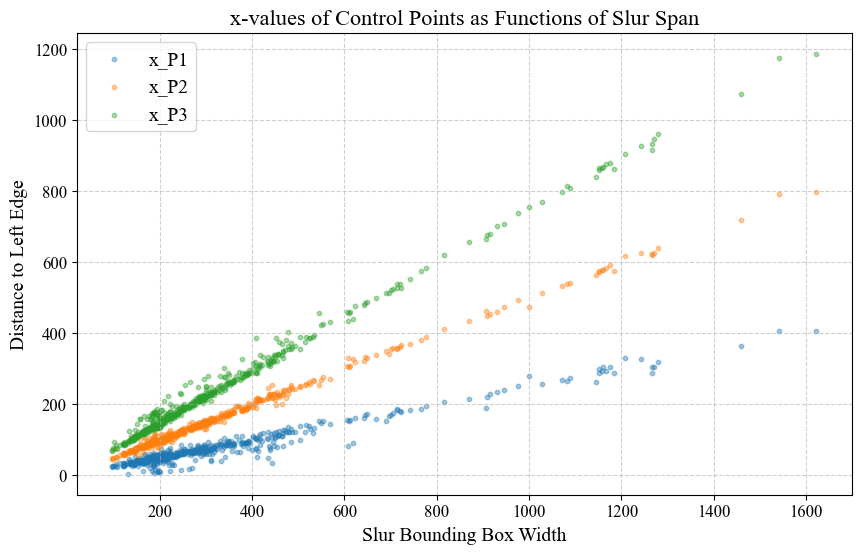

In [5]:
df = pd.read_csv("HN685.csv")

df["BoundingBox in Crop"] = df["BoundingBox in Crop"].apply(parse_bounding_box)
for col in ["P0", "P1", "P2", "P3", "P4"]:
    df[col] = df[col].apply(parse_control_point)

for col in ["P0", "P1", "P2", "P3", "P4"]:
    df[f"x_{col}"] = df[col].apply(lambda p: p[0])
    df[f"y_{col}"] = df[col].apply(lambda p: p[1])
df["x_min"] = df["BoundingBox in Crop"].apply(lambda bbox: bbox[0])
df["y_min"] = df["BoundingBox in Crop"].apply(lambda bbox: bbox[1])
df["x_max"] = df["BoundingBox in Crop"].apply(lambda bbox: bbox[2])
df["y_max"] = df["BoundingBox in Crop"].apply(lambda bbox: bbox[3])

plt.figure(figsize=(10, 6))
plt.scatter(df["x_max"] - df["x_min"], df["x_P1"] - df["x_min"], label="x_P1", alpha=0.4, s=10)
plt.scatter(df["x_max"] - df["x_min"], df["x_P2"] - df["x_min"], label="x_P2", alpha=0.4, s=10)
plt.scatter(df["x_max"] - df["x_min"], df["x_P3"] - df["x_min"], label="x_P3", alpha=0.4, s=10)
plt.xlabel("Slur Bounding Box Width")
plt.ylabel("Distance to Left Edge")
plt.title("x-values of Control Points as Functions of Slur Span")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [6]:
print(min(widths))
print(min(heights))

296
251
